In [1]:
import pandas as pd
import numpy as np
import os

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import balanced_accuracy_score

from sklearn.model_selection import KFold
from sklearn.metrics import recall_score

---
---
Leemos datos

In [2]:
ruta = '/content/drive/MyDrive/TFM/TFM/Processed_Data/DataSetAdenocarcinomaSinOutliers.csv'
dataset = pd.read_csv(ruta, sep="\t")

# Elección de columnas mediante correlación

In [3]:
# Normalizamos las características dentro del rango [0,1]
min_max_scaler = preprocessing.MinMaxScaler()

# Quitamos la columna de ID
columnas = dataset.columns.tolist()
columnas.remove(columnas[0])

features_norm = min_max_scaler.fit_transform(dataset[columnas])

dataset_norm = pd.DataFrame(features_norm, columns=columnas)


correlation_matrix = dataset_norm.corr()

relevant_columns = correlation_matrix[abs(correlation_matrix['Adenocarcinoma']) > 0.05].index
dataset_norm = dataset_norm[relevant_columns]

X = dataset_norm.drop(columns=['Adenocarcinoma'])  # Variables predictoras
y = dataset_norm['Adenocarcinoma']  # Variable objetivo

In [4]:
#definimos funcion para mostrar los resultados
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

LABELS = ["Healthy","Disease"]

def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(9, 9))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

def medidas(cm):
  VP = cm[1][1]
  FP = cm[0][1]
  VN = cm[0][0]
  FN = cm[1][0]
  print("Precision:",round(VP/(VP+FP)*100,2))
  print("Especificidad:",round(VN/(VN+FP)*100,2))
  print("Exactitud:",round((VP+VN)/(VP+VN+FP+FN)*100,2))
  print("Sensibilidad:",round(VP/(VP+FN)*100,2))
  print("Error tipo I:",round(FP/(VN+FP)*100,2))
  print("Error tipo II:",round(FN/(VP+FN)*100,2))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [6]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# Regresión logística

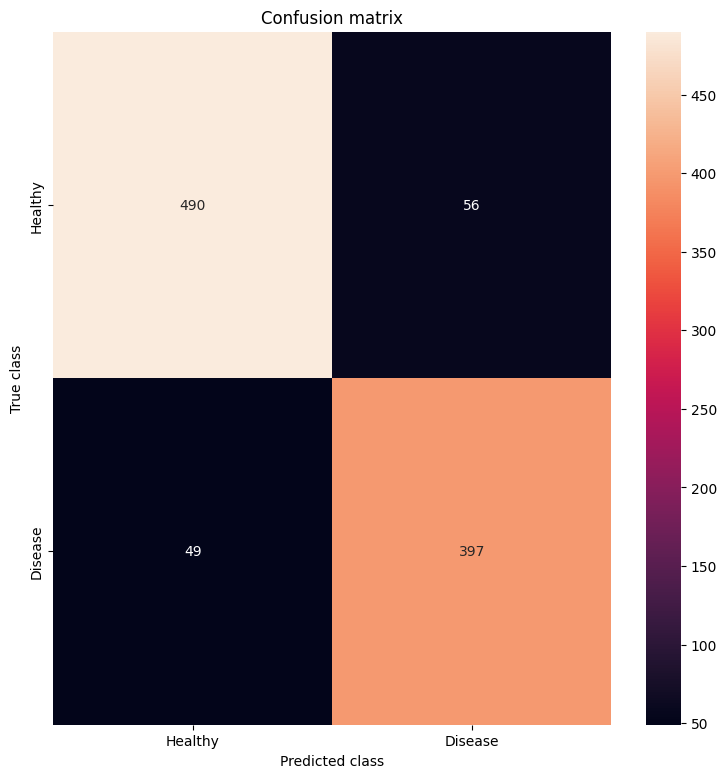

Precision: 87.64
Especificidad: 89.74
Exactitud: 89.42
Sensibilidad: 89.01
Error tipo I: 10.26
Error tipo II: 10.99


In [7]:
# Inicializar y entrenar el modelo de regresión logística
model = LogisticRegression()
model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular la precisión del modelo
mostrar_resultados(y_test, y_pred)

# Mostrar medidas
cm = confusion_matrix(y_test, y_pred)
medidas(cm)

## Random Search

In [8]:
param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Parámetro de regularización
    'penalty': ['l2', None],  # Tipo de penalización
    'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],  # Algoritmo de optimización
}

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


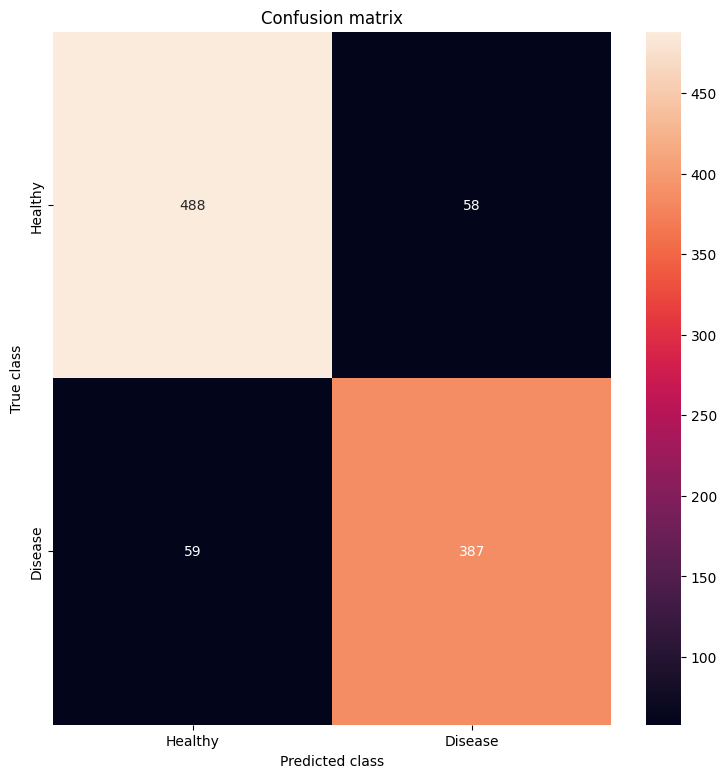

Precision: 86.97
Especificidad: 89.38
Exactitud: 88.21
Sensibilidad: 86.77
Error tipo I: 10.62
Error tipo II: 13.23


In [9]:
# Inicializar y entrenar el modelo de regresión logística
model = LogisticRegression()

# Realizar la búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, scoring=make_scorer(balanced_accuracy_score),
                                   n_iter=100, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model = random_search.best_estimator_

# Predecir en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular la precisión del modelo
mostrar_resultados(y_test, y_pred)

# Mostrar medidas
cm = confusion_matrix(y_test, y_pred)
medidas(cm)

In [10]:
report(random_search.cv_results_, n_top = 3)

Model with rank: 1
Mean validation score: 0.880 (std: 0.015)
Parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 10}

Model with rank: 1
Mean validation score: 0.880 (std: 0.015)
Parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 10}

Model with rank: 3
Mean validation score: 0.880 (std: 0.014)
Parameters: {'solver': 'newton-cholesky', 'penalty': 'l2', 'C': 10}



# Modelo KNN

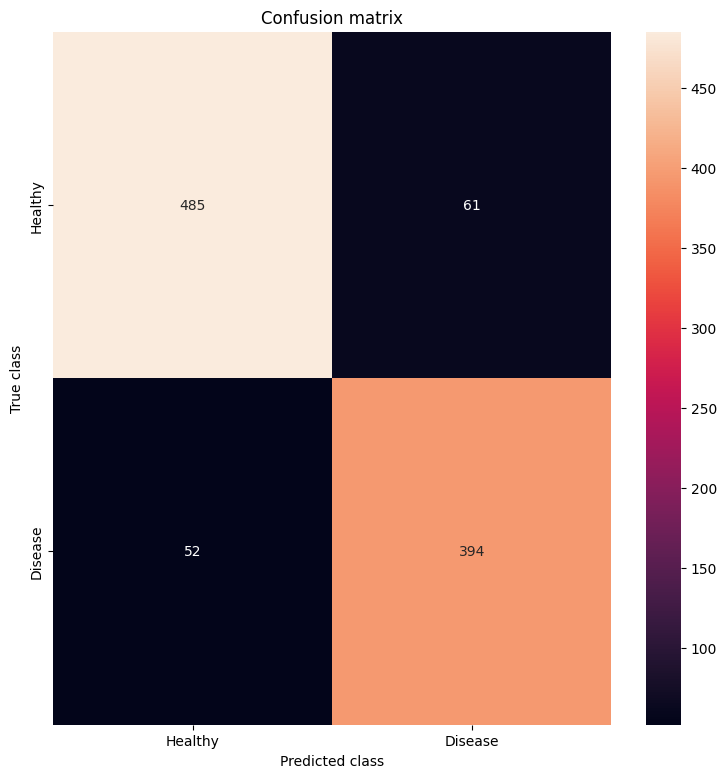

Precision: 86.59
Especificidad: 88.83
Exactitud: 88.61
Sensibilidad: 88.34
Error tipo I: 11.17
Error tipo II: 11.66


In [11]:
# Inicializar el clasificador k-NN
knn = KNeighborsClassifier(n_neighbors=10, weights = 'distance')

# Entrenar el modelo
knn.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = knn.predict(X_test)

# Calcular la precisión del modelo
mostrar_resultados(y_test, y_pred)

# Mostrar medidas
cm = confusion_matrix(y_test, y_pred)
medidas(cm)

## Random Search

In [12]:
param_dist = {
    'n_neighbors': sp_randint(1, 20),  # Número de vecinos
    'weights': ['uniform', 'distance'],  # Método de asignación de pesos
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algoritmo para calcular los vecinos
    'leaf_size': sp_randint(10, 50),  # Tamaño de la hoja para algoritmos de árbol
    'p': [1, 2]  # Parámetro de potencia para la métrica Minkowski
}

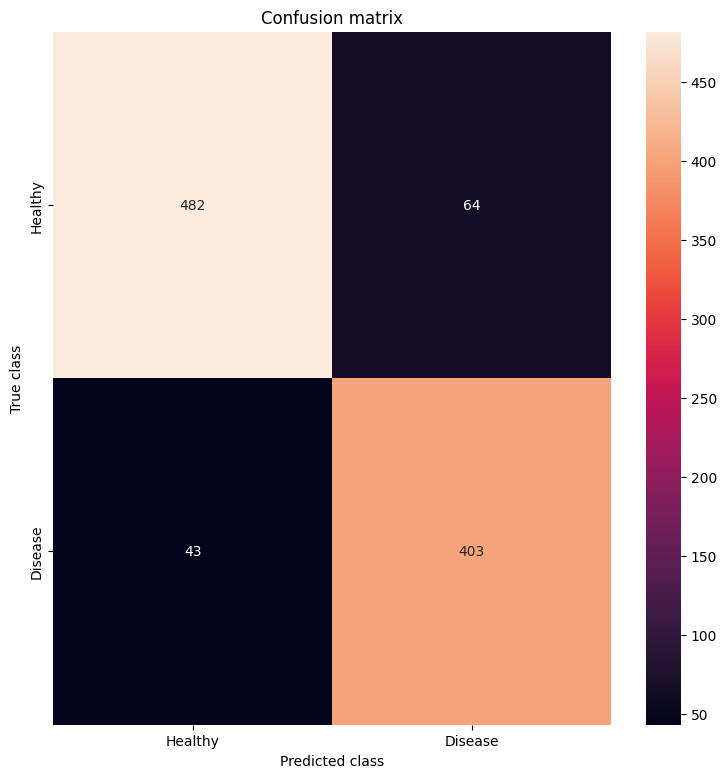

Precision: 86.3
Especificidad: 88.28
Exactitud: 89.21
Sensibilidad: 90.36
Error tipo I: 11.72
Error tipo II: 9.64


In [13]:
# Inicializar el clasificador k-NN
knn = KNeighborsClassifier()

# Realizar la búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(estimator=knn, param_distributions=param_dist, scoring=make_scorer(balanced_accuracy_score),
                                   n_iter=100, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model = random_search.best_estimator_

# Realizar predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular la precisión del modelo
mostrar_resultados(y_test, y_pred)

# Mostrar medidas
cm = confusion_matrix(y_test, y_pred)
medidas(cm)

# Modelo Árbol de Decisión

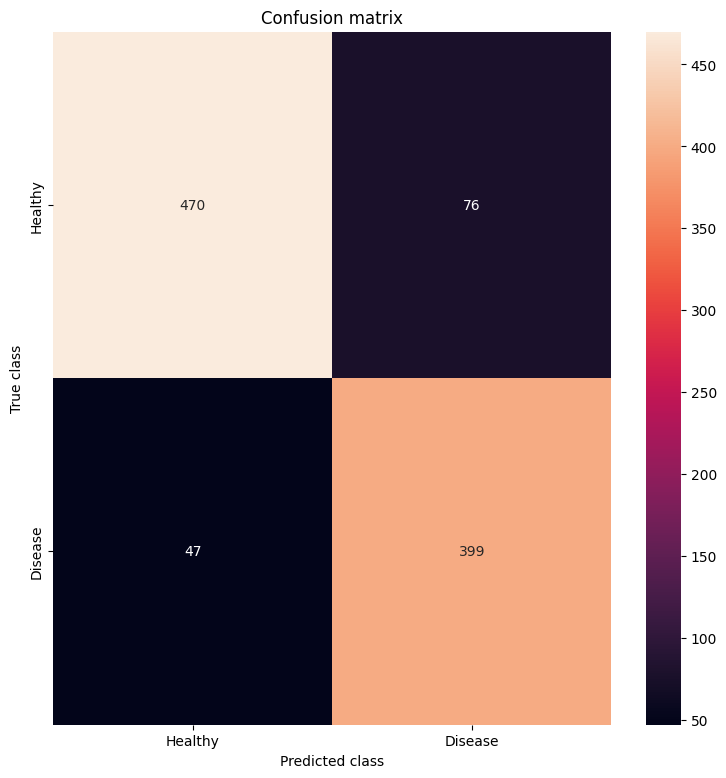

Precision: 84.0
Especificidad: 86.08
Exactitud: 87.6
Sensibilidad: 89.46
Error tipo I: 13.92
Error tipo II: 10.54


In [14]:
# Inicializar el clasificador de árbol de decisión
dt_classifier = DecisionTreeClassifier(max_depth=10, random_state=42)

# Entrenar el modelo
dt_classifier.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = dt_classifier.predict(X_test)

# Calcular la precisión del modelo
mostrar_resultados(y_test, y_pred)

# Mostrar medidas
cm = confusion_matrix(y_test, y_pred)
medidas(cm)

## Random Search

In [15]:
param_dist = {
    'criterion': ['gini', 'entropy'],  # Criterio de calidad de la partición
    'splitter': ['best', 'random'],  # Estrategia para elegir la división en cada nodo
    'max_depth': [None] + list(sp_randint(1, 20).rvs(10)),  # Profundidad máxima del árbol
    'min_samples_split': sp_randint(2, 20),  # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': sp_randint(1, 20),  # Número mínimo de muestras requeridas para ser una hoja
    'max_features': ['auto', 'sqrt', 'log2', None],  # Número máximo de características a considerar en cada división
    'ccp_alpha': np.linspace(0.0, 0.5, 10)  # Parámetro de complejidad de coste mínimo
}

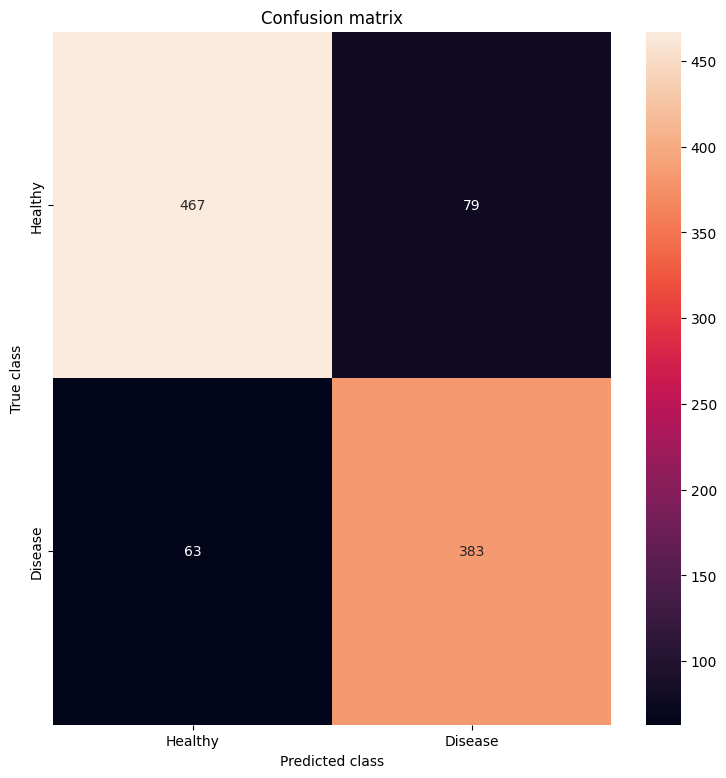

Precision: 82.9
Especificidad: 85.53
Exactitud: 85.69
Sensibilidad: 85.87
Error tipo I: 14.47
Error tipo II: 14.13


In [16]:
# Inicializar el clasificador de árbol de decisión
dt_classifier = DecisionTreeClassifier()

# Realizar la búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(estimator=dt_classifier, param_distributions=param_dist, scoring=make_scorer(balanced_accuracy_score),
                                   n_iter=100, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model = random_search.best_estimator_

# Realizar predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular la precisión del modelo
mostrar_resultados(y_test, y_pred)

# Mostrar medidas
cm = confusion_matrix(y_test, y_pred)
medidas(cm)

# Modelo Bosque Aleatorio

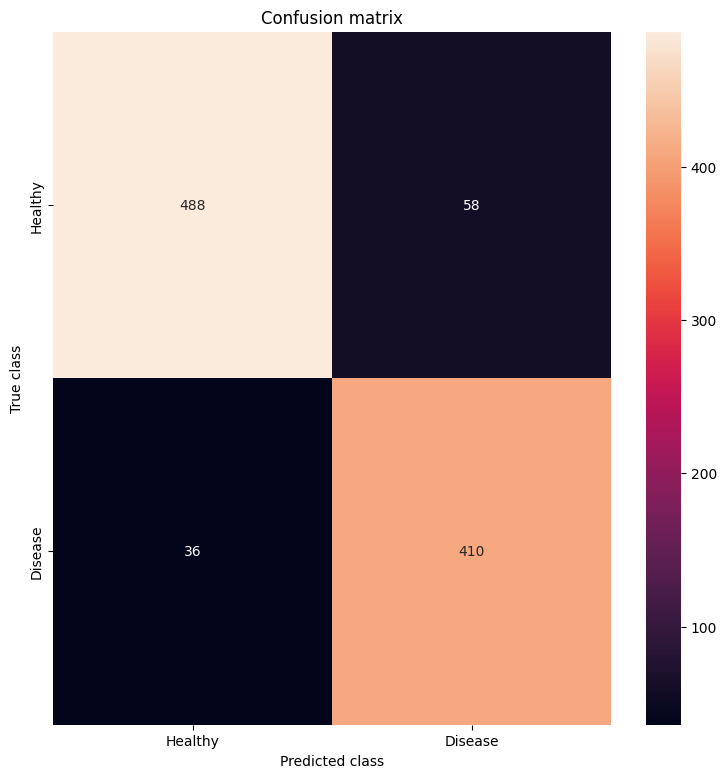

Precision: 87.61
Especificidad: 89.38
Exactitud: 90.52
Sensibilidad: 91.93
Error tipo I: 10.62
Error tipo II: 8.07


In [17]:
# Inicializar el clasificador de bosque aleatorio
rf_regressor  = RandomForestClassifier(max_depth=10, random_state=42)

# Entrenar el modelo
rf_regressor.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = rf_regressor .predict(X_test)

# Calcular la precisión del modelo
mostrar_resultados(y_test, y_pred)

# Mostrar medidas
cm = confusion_matrix(y_test, y_pred)
medidas(cm)

## Random Search

In [18]:
param_dist = {"n_estimators": [8, 16, 32], # Número de árboles en el bosque aleatorio
              "max_features": ['auto', 'sqrt'], # Número de características a considerar en cada división
              "max_depth": [12, 8, 4], # Número máximo de niveles en el árbol
              "min_samples_split": sp_randint(2, 10), # Número mínimo de muestras requeridas para dividir un nodo
              "min_samples_leaf": sp_randint(1, 10), # Número mínimo de muestras requeridas en cada nodo hoja
              "bootstrap": [True, False], # Método de selección de muestras para entrenar cada árbol
              "criterion": ['log_loss', 'entropy', 'gini']} # Criterio de evaluación de la calidad de una división

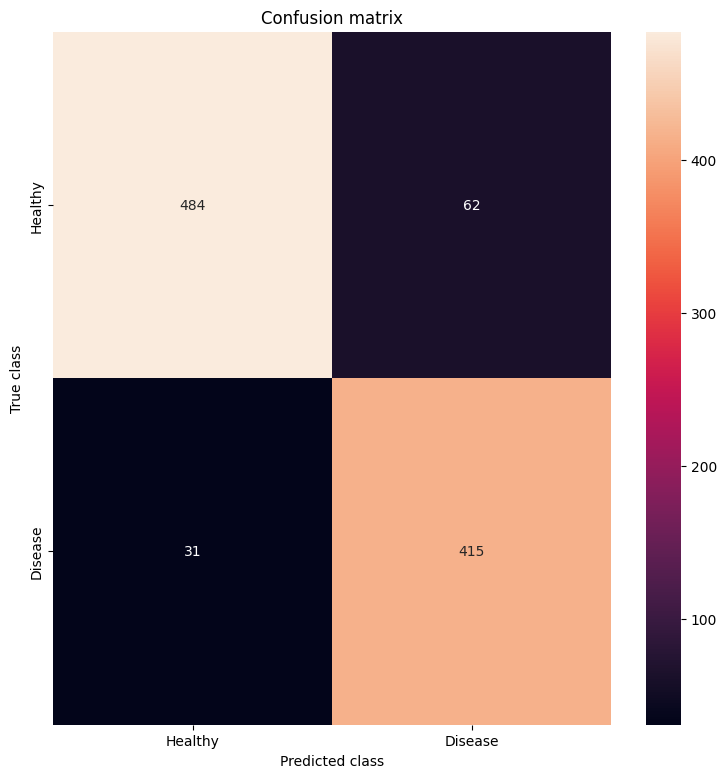

Precision: 87.0
Especificidad: 88.64
Exactitud: 90.62
Sensibilidad: 93.05
Error tipo I: 11.36
Error tipo II: 6.95


In [19]:
classifier =  RandomForestClassifier()

# Realizar la búsqueda aleatoria de hiperparámetros
rnd_class = RandomizedSearchCV(estimator = classifier, param_distributions = param_dist,
                               n_iter = 100, cv = 5, random_state=42, n_jobs = -1,
                               scoring=make_scorer(balanced_accuracy_score))
rnd_class.fit(X_train, y_train)

# Inicializar el clasificador de bosque de árboles de decisión
classifier =  rnd_class.best_estimator_

# Realizar predicciones en el conjunto de prueba
y_pred = classifier.predict(X_test)

# Calcular la precisión del modelo
mostrar_resultados(y_test, y_pred)

# Mostrar medidas
cm = confusion_matrix(y_test, y_pred)
medidas(cm)

# Red neuronal

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Flatten
from tensorflow.keras.utils import plot_model
import keras.backend as K

In [21]:
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [22]:
# Define la arquitectura de la red neuronal
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),  # Capa oculta con activación ReLU
    Dropout(0.5),  # Dropout para regularización
    Dense(8, activation='relu'),  # capa oculta
    Dense(1, activation='relu')  # Capa de salida
])

# Compila el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy', specificity])

# Entrena el modelo
model.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
100/100 [==============================] - 3s 13ms/step - loss: 1.3113 - accuracy: 0.5807 - specificity: 0.9509 - val_loss: 0.5825 - val_accuracy: 0.6562 - val_specificity: 0.9196
Epoch 2/50
100/100 [==============================] - 0s 4ms/step - loss: 0.5672 - accuracy: 0.6745 - specificity: 0.9227 - val_loss: 0.4385 - val_accuracy: 0.7846 - val_specificity: 0.8701
Epoch 3/50
100/100 [==============================] - 0s 4ms/step - loss: 0.4434 - accuracy: 0.7599 - specificity: 0.9048 - val_loss: 0.4375 - val_accuracy: 0.8388 - val_specificity: 0.9050
Epoch 4/50
100/100 [==============================] - 0s 4ms/step - loss: 0.4163 - accuracy: 0.7990 - specificity: 0.8964 - val_loss: 0.4162 - val_accuracy: 0.8577 - val_specificity: 0.8593
Epoch 5/50
100/100 [==============================] - 1s 7ms/step - loss: 0.3920 - accuracy: 0.8217 - specificity: 0.9039 - val_loss: 0.4410 - val_accuracy: 0.8526 - val_specificity: 0.8949
Epoch 6/50
100/100 [=============================

31/31 [==============================] - 0s 2ms/step


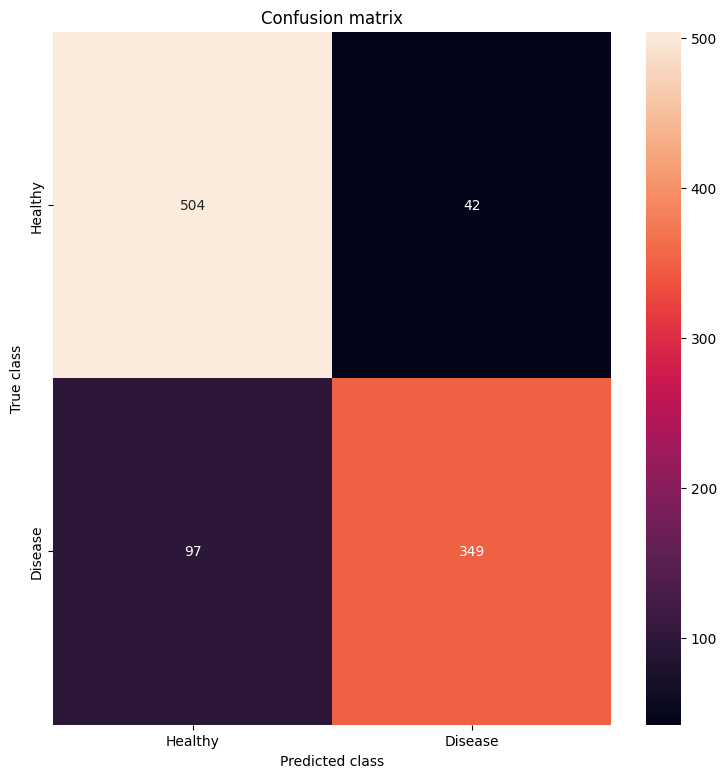

Precision: 89.26
Especificidad: 92.31
Exactitud: 85.99
Sensibilidad: 78.25
Error tipo I: 7.69
Error tipo II: 21.75


In [23]:
# Evaluar el modelo en el conjunto de prueba (si tienes uno)
# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

# Calcular la precisión del modelo
mostrar_resultados(y_test, y_pred)

# Mostrar medidas
cm = confusion_matrix(y_test, y_pred)
medidas(cm)